# Dependency 

In [ ]:
!pip3 install nltk
!pip3 install matplotlib

In [4]:
!pip3 install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 5.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 7.5 MB/s eta 0:00:0000:0100:01


In [5]:
from bs4 import BeautifulSoup
from datetime import datetime
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import random
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import numpy as np

# Data Cleaning & Extraction (TODO: Need modifying once we have the extraction agent)

#### Parse Huntr

In [6]:
def clean_date(date_text):
    # Remove ordinal suffixes from the date
    return re.sub(r'(\d)(st|nd|rd|th)', r'\1', date_text)

def parse_metadata_for_huntr(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
        
    soup = BeautifulSoup(html_content, 'html.parser')
    
    metadata = {}
    
    # Extract the repo name from the hyperlink in the title
    title_tag = soup.find('h1', {'id': 'title'})
    if title_tag:
        repo_link = title_tag.find('a', href=True)
        if repo_link:
            metadata['repo_name'] = repo_link.get_text(strip=True)
        metadata['bug_description'] = title_tag.get_text(strip=True)
    
    # Extract the date
    date_element = soup.find(string=re.compile(r'Reported on (\w+ \d{1,2}(?:st|nd|rd|th) \d{4})'))
    if date_element:
        date_match = re.search(r'Reported on (\w+ \d{1,2}(?:st|nd|rd|th) \d{4})', date_element)
        if date_match:
            date_text = clean_date(date_match.group(1))
            try:
                parsed_date = datetime.strptime(date_text, "%b %d %Y")
                metadata['date'] = parsed_date
            except ValueError:
                metadata['date'] = date_text
    
    bounty_awarded=False
    
    # Extract Disclosure Bounty
    disclosure_bounty_value = '0'
    bounty_elements = soup.find_all(string=re.compile(r'\bDisclosure\s+Bounty\b', re.IGNORECASE))
    for elem in bounty_elements:
        # Find closest dollar amount to "Disclosure Bounty"
        next_sibling = elem.find_next(string=re.compile(r'\$\d+(\.\d+)?'))
        if 'awarded' in elem.lower() and 'disclosure bounty' in elem.lower():
            bounty_awarded=True
        if next_sibling:
            disclosure_bounty_value = re.search(r'\$\d+(\.\d+)?', next_sibling)
            if disclosure_bounty_value:
                disclosure_bounty_value = disclosure_bounty_value.group().replace('$', '').replace(',', '')
                break

    metadata['disclosure_bounty'] = disclosure_bounty_value
    metadata['bounty_award_status'] = bounty_awarded
    
    # Extract CWE
    cwe_elements = soup.find_all('a', href=lambda href: href and "cwe" in href)
    cwes = [elem.get_text(strip=True) for elem in cwe_elements]
    metadata['cwe'] = cwes

    #Extract CVE
    cve_element = soup.find('a', href=lambda href: href and "nvd.nist.gov" in href)
    metadata['cve']= cve_element.text.strip() if cve_element else ""
    
    return metadata

def extract_metadata_from_folder(folder_path):
    metadata_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".html"):
            file_path = os.path.join(folder_path, filename)
            metadata = parse_metadata_for_huntr(file_path)
            metadata_dict[filename] = metadata
    
    return metadata_dict

In [7]:
folder_path = "./huntr"  
huntr_metadata_dict = extract_metadata_from_folder(folder_path)
print(len(huntr_metadata_dict))
print(list(huntr_metadata_dict.items())[:10])

1576
[('5c147ff8-3cc4-4f21-9f1c-13fd50957dad.html', {'repo_name': 'pkp/pkp-lib', 'bug_description': 'STORED XSS in Journal-> Sections inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 15, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - Stored'], 'cve': 'CVE-2023-5903'}), ('566033b9-df20-4928-b4aa-5cd4c3ca1561.html', {'repo_name': 'langchain-ai/chat-langchain', 'bug_description': 'XSS through Longchain-AI chat inlangchain-ai/chat-langchain', 'date': datetime.datetime(2024, 1, 16, 0, 0), 'disclosure_bounty': '125', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - DOM'], 'cve': 'CVE-2024-0968'}), ('59be0d5a-f18e-4418-8f29-72320269a097.html', {'repo_name': 'parisneo/lollms-webui', 'bug_description': 'Insecure model output handling leading to RCE inparisneo/lollms-webui', 'date': datetime.datetime(2024, 2, 7, 0, 0), 'disclosure_bounty': '450', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scrip

#### Parse Hackerone (place holder) 

In [ ]:
#merge huntr and hackerone dict 
def merge_dictionaries(dict1, dict2):
    for repo, entries in dict2.items():
        if repo not in dict1:
            dict1[repo] = []
        existing_cves = {entry['cve'] for entry in dict1[repo]}
        for entry in entries:
            if entry['cve'] not in existing_cves:
                dict1[repo].append(entry)
    return dict1

# Merge the dictionaries
merged_dict = merge_dictionaries(huntr_metadata_dict, hackerone_metadata_dict)

# Print the merged dictionary
for repo, entries in merged_dict.items():
    print(f"Repository: {repo}")
    for entry in entries:
        print(entry)
    print()

In [8]:
grouped_dict = defaultdict(list)
original_dict=huntr_metadata_dict.copy()

def group_by_repo_name(original_dict):
    grouped_dict = defaultdict(list)

    for html_file, metadata in original_dict.items():
        # Check if 'repo_name' exists in metadata
        if 'repo_name' not in metadata:
            #print(f"Warning: 'repo_name' not found in file: {html_file}")
            continue  # Skip if 'repo_name' is missing

        repo_name = metadata['repo_name']
        entry = {k: v for k, v in metadata.items() if k != 'repo_name'}
        grouped_dict[repo_name].append(entry)
    
    grouped_dict = dict(grouped_dict)

    return grouped_dict

result = group_by_repo_name(original_dict)

# Print the grouped dictionary
for repo, entries in result.items():
    print(f"Repository: {repo}")
    for entry in entries:
        print(entry)
    print()

Repository: pkp/pkp-lib
{'bug_description': 'STORED XSS in Journal-> Sections inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 15, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - Stored'], 'cve': 'CVE-2023-5903'}
{'bug_description': 'Stored xss using journal-name inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 11, 0, 0), 'disclosure_bounty': '15', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - Reflected'], 'cve': 'CVE-2023-5891'}
{'bug_description': 'Stored xss using journal-name in journal-tab inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 11, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - Stored'], 'cve': 'CVE-2023-5904'}
{'bug_description': 'CSRF in Review Details inpkp/pkp-lib', 'date': datetime.datetime(2023, 10, 12, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-352: Cross-Site Request Forgery (CS

In [9]:
#Sort result by date 
# Re-using the parse_date function defined above
def parse_date(date_str):
    # Remove suffixes like 'st', 'nd', 'rd', 'th'
    date_str = re.sub(r'(\d{1,2})(st|nd|rd|th)', r'\1', date_str)
    
    for fmt in ("%b %d %Y",):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"No valid date format found for {date_str}")

def group_by_repo_name(original_dict):
    grouped_dict = defaultdict(list)

    for html_file, metadata in original_dict.items():
        # Check if 'repo_name' exists in metadata
        if 'repo_name' not in metadata:
            continue  # Skip if 'repo_name' is missing

        repo_name = metadata['repo_name']
        # Append all other metadata fields except 'repo_name'
        entry = {k: v for k, v in metadata.items() if k != 'repo_name'}
        grouped_dict[repo_name].append(entry)

    # Sort entries by date for each repo
    for repo_name in grouped_dict:
        try:
            grouped_dict[repo_name].sort(key=lambda x: x['date'])  # Assuming date is already a datetime object
        except ValueError as e:
            print(e)

    grouped_dict = dict(grouped_dict)

    return grouped_dict

sorted_result = group_by_repo_name(original_dict)

for repo_name, entries in sorted_result.items():
    print(f"Repository: {repo_name}")
    for entry in entries:
        print(entry)
    print()

Repository: pkp/pkp-lib
{'bug_description': 'Use of predictable RNG for password generation inpkp/pkp-lib', 'date': datetime.datetime(2023, 7, 5, 0, 0), 'disclosure_bounty': '75', 'bounty_award_status': True, 'cwe': ['CWE-1241: Use of Predictable Algorithm in Random Number Generator'], 'cve': 'CVE-2023-4695'}
{'bug_description': 'Cross-Site Scripting ( XSS) Via file upload inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 1, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-434: Unrestricted Upload of File with Dangerous Type'], 'cve': 'CVE-2023-5901'}
{'bug_description': 'Stored XSS in module named "New Submissions"  inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 3, 0, 0), 'disclosure_bounty': '5', 'bounty_award_status': True, 'cwe': ['CWE-79: Cross-site Scripting (XSS) - DOM'], 'cve': 'CVE-2023-5895'}
{'bug_description': 'Stored xss using journal-name inpkp/pkp-lib', 'date': datetime.datetime(2023, 9, 11, 0, 0), 'disclosure_bounty': '15', 'bounty_award_s

# Data Analysis

In [9]:
result=sorted_result

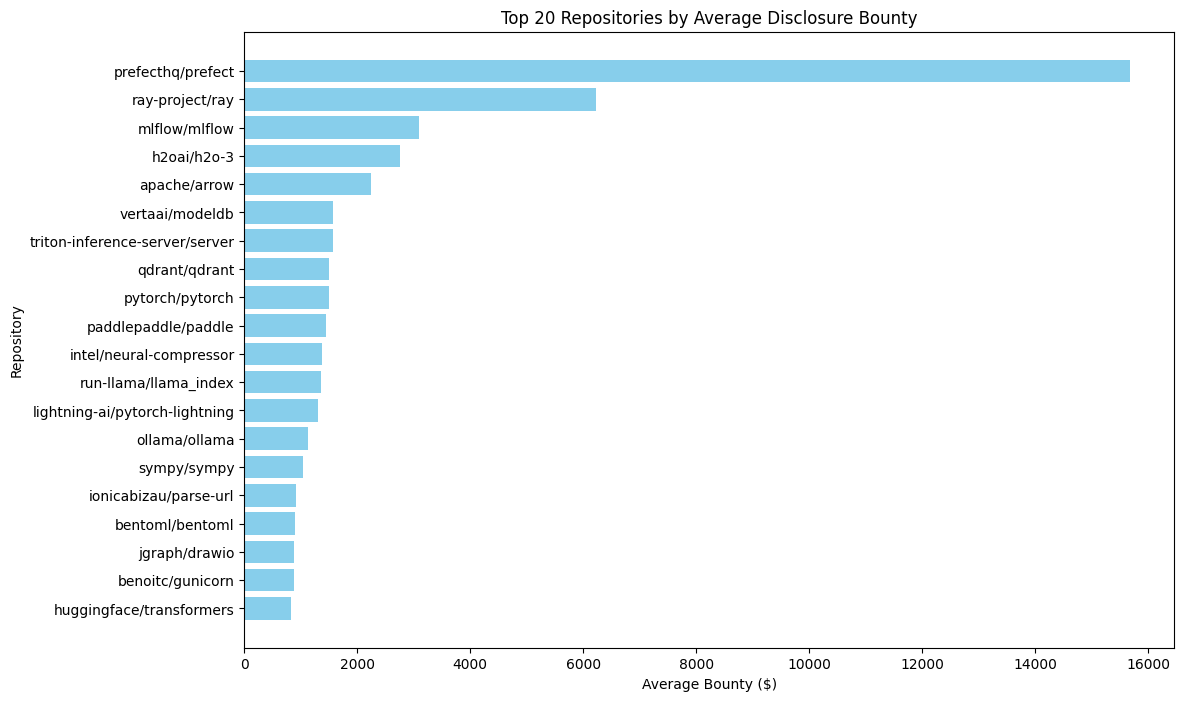

In [10]:
def calculate_average_bounty(grouped_dict):
    bounty_dict = {}

    for repo, entries in grouped_dict.items():
        total_bounty = 0
        bounty_count = 0
        
        for entry in entries:
            bounty = entry.get('disclosure_bounty', '0')
            try:
                bounty = float(bounty)
            except ValueError:
                continue  # Skip entries where the bounty is not a valid number
            
            if bounty > 0:
                total_bounty += bounty
                bounty_count += 1
        
        if bounty_count > 0:
            average_bounty = total_bounty / bounty_count
            bounty_dict[repo] = average_bounty
    
    return bounty_dict

def plot_average_bounty(bounty_dict, top_n=20):
    # Sort repositories by average bounty in descending order and select top N
    sorted_bounty_dict = dict(sorted(bounty_dict.items(), key=lambda item: item[1], reverse=True)[:top_n])
    
    repos = list(sorted_bounty_dict.keys())
    avg_bounties = [sorted_bounty_dict[repo] for repo in repos]
    
    plt.figure(figsize=(12, 8))
    plt.barh(repos, avg_bounties, color='skyblue')
    plt.xlabel('Average Bounty ($)')
    plt.ylabel('Repository')
    plt.title('Top {} Repositories by Average Disclosure Bounty'.format(top_n))
    plt.gca().invert_yaxis()  
    plt.show()


bounty_dict = calculate_average_bounty(result)
plot_average_bounty(bounty_dict)

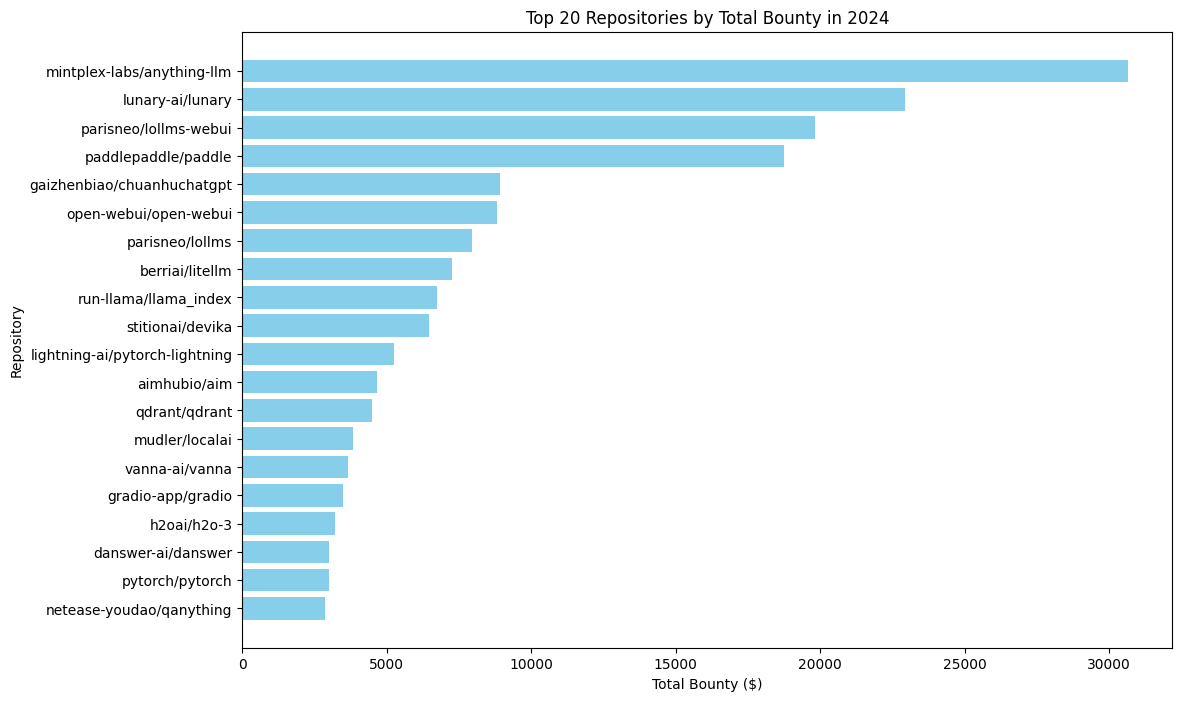

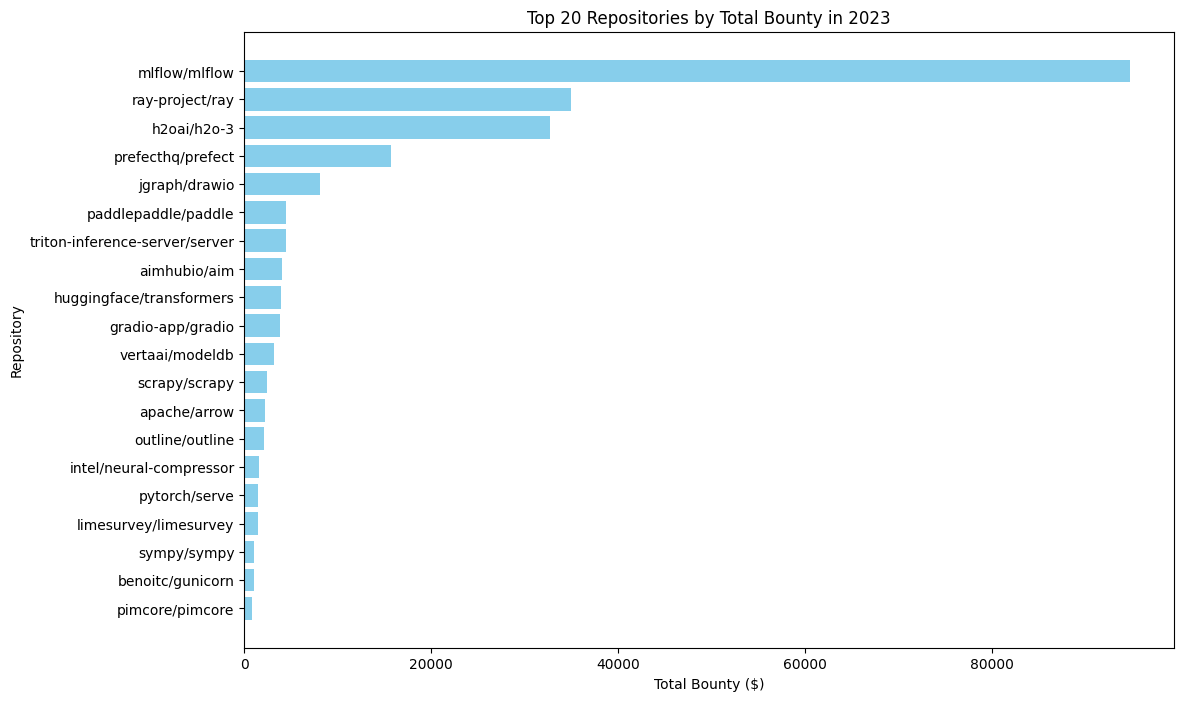

In [11]:
def calculate_total_bounty_for_year(grouped_dict, target_year):
    bounty_dict = {}

    for repo, entries in grouped_dict.items():
        total_bounty = 0
        
        for entry in entries:
            bounty = entry.get('disclosure_bounty', '0')
            date = entry.get('date', None)
            
            if isinstance(date, datetime) and date.year == target_year:
                try:
                    bounty = float(bounty)
                except ValueError:
                    continue  # Skip entries where the bounty is not a valid number
                
                if bounty > 0:
                    total_bounty += bounty
        
        if total_bounty > 0:
            bounty_dict[repo] = total_bounty
    
    return bounty_dict

def plot_total_bounty(bounty_dict, year, top_n=20):
    # Sort repositories by total bounty in descending order and select top N
    sorted_bounty_dict = dict(sorted(bounty_dict.items(), key=lambda item: item[1], reverse=True)[:top_n])
    
    repos = list(sorted_bounty_dict.keys())
    total_bounties = [sorted_bounty_dict[repo] for repo in repos]
    
    plt.figure(figsize=(12, 8))
    plt.barh(repos, total_bounties, color='skyblue')
    plt.xlabel('Total Bounty ($)')
    plt.ylabel('Repository')
    plt.title(f'Top {top_n} Repositories by Total Bounty in {year}')
    plt.gca().invert_yaxis()  
    plt.show()

# Assuming result is already populated with metadata
# For year 2024
bounty_dict_2024 = calculate_total_bounty_for_year(result, 2024)
plot_total_bounty(bounty_dict_2024, 2024)

# For year 2023
bounty_dict_2023 = calculate_total_bounty_for_year(result, 2023)
plot_total_bounty(bounty_dict_2023, 2023)

In [12]:
#Total bounty amount per year 
def aggregate_bounty_per_year(dataset):
    bounty_per_year = defaultdict(lambda: defaultdict(float))

    for repo, entries in dataset.items():
        for entry in entries:
            # Assuming the date field is already a datetime object
            date = entry['date']
            if isinstance(date, datetime):
                year = date.year
                try:
                    bounty = float(entry['disclosure_bounty'])
                    bounty_per_year[repo][year] += bounty
                except ValueError:
                    continue

    return bounty_per_year

# Get total bounty per year
total_bounty_per_year = aggregate_bounty_per_year(result)

# Print the aggregated bounty values
for repo, yearly_bounty in total_bounty_per_year.items():
    print(f"Repository: {repo}")
    for year, total_bounty in yearly_bounty.items():
        print(f"  Year: {year}, Total Bounty: ${total_bounty:.2f}")

Repository: pkp/pkp-lib
  Year: 2023, Total Bounty: $195.00
Repository: langchain-ai/chat-langchain
  Year: 2024, Total Bounty: $125.00
Repository: parisneo/lollms-webui
  Year: 2024, Total Bounty: $19831.00
Repository: gpac/gpac
  Year: 2022, Total Bounty: $44.00
  Year: 2023, Total Bounty: $462.00
Repository: parisneo/lollms
  Year: 2024, Total Bounty: $7965.00
Repository: firefly-iii/firefly-iii
  Year: 2023, Total Bounty: $44.00
Repository: omeka/omeka-s
  Year: 2023, Total Bounty: $88.00
Repository: nuxtlabs/github-module
  Year: 2023, Total Bounty: $11.00
Repository: froxlor/froxlor
  Year: 2022, Total Bounty: $140.00
  Year: 2023, Total Bounty: $571.00
Repository: mintplex-labs/anything-llm
  Year: 2023, Total Bounty: $55.00
  Year: 2024, Total Bounty: $30656.00
Repository: os4ed/opensis-classic
  Year: 2021, Total Bounty: $22.00
  Year: 2022, Total Bounty: $11.00
Repository: pimcore/pimcore
  Year: 2022, Total Bounty: $22.00
  Year: 2023, Total Bounty: $808.00
Repository: thors

In [13]:
#Average bounty per cwe per repo 
def aggregate_average_bounty_per_cwe(dataset):
    cwe_bounty_data = defaultdict(lambda: defaultdict(list))
    cwe_average_bounty = defaultdict(lambda: defaultdict(float))

    for repo, entries in dataset.items():
        for entry in entries:
            bounty = float(entry.get('disclosure_bounty', '0'))
            if bounty > 0:  # Only consider positive bounties
                for cwe in entry.get('cwe', []):
                    cwe_key = cwe.split(":")[0].strip()
                    cwe_bounty_data[repo][cwe_key].append(bounty)

    for repo, cwes in cwe_bounty_data.items():
        for cwe, bounties in cwes.items():
            cwe_average_bounty[repo][cwe] = sum(bounties) / len(bounties)
    
    return cwe_average_bounty

# Get average bounty per CWE for each repository
average_bounty_per_cwe = aggregate_average_bounty_per_cwe(result)

# Sort CWEs by average bounty and print the results
for repo, cwe_data in average_bounty_per_cwe.items():
    sorted_cwe_data = sorted(cwe_data.items(), key=lambda item: item[1], reverse=True)
    print(f"Repository: {repo}")
    for cwe, average_bounty in sorted_cwe_data:
        print(f"  CWE: {cwe}, Average Bounty: ${average_bounty:.2f}")

Repository: pkp/pkp-lib
  CWE: CWE-1241, Average Bounty: $75.00
  CWE: CWE-613, Average Bounty: $15.00
  CWE: CWE-79, Average Bounty: $9.29
  CWE: CWE-352, Average Bounty: $7.50
  CWE: CWE-434, Average Bounty: $5.00
  CWE: CWE-862, Average Bounty: $5.00
Repository: langchain-ai/chat-langchain
  CWE: CWE-79, Average Bounty: $125.00
Repository: parisneo/lollms-webui
  CWE: CWE-98, Average Bounty: $900.00
  CWE: CWE-15, Average Bounty: $900.00
  CWE: CWE-78, Average Bounty: $750.00
  CWE: CWE-77, Average Bounty: $675.00
  CWE: CWE-29, Average Bounty: $637.50
  CWE: CWE-288, Average Bounty: $630.00
  CWE: CWE-36, Average Bounty: $468.75
  CWE: CWE-89, Average Bounty: $450.00
  CWE: CWE-749, Average Bounty: $450.00
  CWE: CWE-918, Average Bounty: $450.00
  CWE: CWE-76, Average Bounty: $450.00
  CWE: CWE-346, Average Bounty: $450.00
  CWE: CWE-79, Average Bounty: $262.50
  CWE: CWE-352, Average Bounty: $235.71
  CWE: CWE-22, Average Bounty: $150.67
  CWE: CWE-400, Average Bounty: $75.00
  CW

In [14]:
def calculate_bounty_award_status_percentage(merged_dict):
    percentage_dict = {}
    
    for repo, entries in merged_dict.items():
        total_count = 0
        true_count = 0
        for entry in entries:
            bounty = float(entry.get('disclosure_bounty', 0))
            if bounty > 0:
                total_count += 1
                if entry.get('bounty_award_status', False):
                    true_count += 1
        
        if total_count > 0:
            percentage_dict[repo] = (true_count / total_count) * 100
    
    return percentage_dict

percentage_dict = calculate_bounty_award_status_percentage(result)

print("Percentage of success bounty over all bounties per repo")
for repo, percentage in percentage_dict.items():
    print(f"Repository: {repo}, Percentage: {percentage:.2f}%")

Percentage of success bounty over all bounties per repo
Repository: pkp/pkp-lib, Percentage: 100.00%
Repository: langchain-ai/chat-langchain, Percentage: 100.00%
Repository: parisneo/lollms-webui, Percentage: 100.00%
Repository: gpac/gpac, Percentage: 100.00%
Repository: parisneo/lollms, Percentage: 94.12%
Repository: firefly-iii/firefly-iii, Percentage: 100.00%
Repository: omeka/omeka-s, Percentage: 100.00%
Repository: nuxtlabs/github-module, Percentage: 100.00%
Repository: froxlor/froxlor, Percentage: 100.00%
Repository: mintplex-labs/anything-llm, Percentage: 80.39%
Repository: os4ed/opensis-classic, Percentage: 100.00%
Repository: pimcore/pimcore, Percentage: 93.62%
Repository: thorsten/phpmyfaq, Percentage: 98.70%
Repository: usememos/memos, Percentage: 100.00%
Repository: bits-and-blooms/bloom, Percentage: 100.00%
Repository: lunary-ai/lunary, Percentage: 97.22%
Repository: dolibarr/dolibarr, Percentage: 100.00%
Repository: open-webui/open-webui, Percentage: 95.65%
Repository: ga

In [15]:
#Most common CWE acorss ALL repo 
from collections import defaultdict, Counter
def top_n_most_common_cwes(merged_dict, top_n=10):
    cwe_counter = Counter()

    for repo, entries in merged_dict.items():
        for entry in entries:
            cwes = entry.get('cwe', [])
            for cwe in cwes:
                cwe_counter[cwe] += 1

    return cwe_counter.most_common(top_n)

# Calculate top 10 most common CWEs across all repositories
top_cwes = top_n_most_common_cwes(result, top_n=10)

print("Top 10 Most Common CWEs:")
for cwe, count in top_cwes:
    print(f"{cwe}: {count} occurrences")

Top 10 Most Common CWEs:
CWE-79: Cross-site Scripting (XSS) - Stored: 270 occurrences
CWE-79: Cross-site Scripting (XSS) - Reflected: 85 occurrences
CWE-352: Cross-Site Request Forgery (CSRF): 83 occurrences
CWE-284: Improper Access Control: 66 occurrences
CWE-89:  SQL Injection: 46 occurrences
CWE-94:  Code Injection: 46 occurrences
CWE-29: Path Traversal: '\..\filename': 45 occurrences
CWE-22: Path Traversal: 44 occurrences
CWE-79: Cross-site Scripting (XSS) - Generic: 44 occurrences
CWE-20: Improper Input Validation: 39 occurrences


Most expensive CWEs by avg bounty

In [16]:
def calculate_average_bounties(result_dict):
    cwe_bounty_sum = defaultdict(float)
    cwe_bounty_count = defaultdict(int)
    
    repo_cwe_bounty_sum = defaultdict(lambda: defaultdict(float))
    repo_cwe_bounty_count = defaultdict(lambda: defaultdict(int))
    
    for repo, entries in result_dict.items():
        for entry in entries:
            bounty = float(entry.get('disclosure_bounty', 0))
            if bounty > 0:
                cwes = entry.get('cwe', [])
                for cwe in cwes:
                    cwe_bounty_sum[cwe] += bounty
                    cwe_bounty_count[cwe] += 1
                    repo_cwe_bounty_sum[repo][cwe] += bounty
                    repo_cwe_bounty_count[repo][cwe] += 1
                    
    overall_cwe_avg_bounty = {cwe: cwe_bounty_sum[cwe] / cwe_bounty_count[cwe] for cwe in cwe_bounty_sum}
    repo_cwe_avg_bounty = {
        repo: {cwe: repo_cwe_bounty_sum[repo][cwe] / repo_cwe_bounty_count[repo][cwe] for cwe in repo_cwe_bounty_sum[repo]}
        for repo in repo_cwe_bounty_sum
    }
    
    return overall_cwe_avg_bounty, repo_cwe_avg_bounty

overall_cwe_avg_bounty, repo_cwe_avg_bounty = calculate_average_bounties(result)

In [17]:
def find_most_expensive_cwes(overall_avg_bounty, repo_avg_bounty):
    most_expensive_overall = max(overall_avg_bounty.items(), key=lambda item: item[1])
    
    most_expensive_per_repo = {
        repo: max(cwes.items(), key=lambda item: item[1]) 
        for repo, cwes in repo_avg_bounty.items()
    }
    
    return most_expensive_overall, most_expensive_per_repo

most_expensive_overall, most_expensive_per_repo = find_most_expensive_cwes(overall_cwe_avg_bounty, repo_cwe_avg_bounty)

# Print the results
print(f"Most Expensive CWE Overall:")
print(f"{most_expensive_overall[0]} with average bounty of ${most_expensive_overall[1]:.2f}")

print("\nMost Expensive CWE Per Repository:")
for repo, (cwe, avg_bounty) in most_expensive_per_repo.items():
    print(f"Repository: {repo}, CWE: {cwe}, Average Bounty: ${avg_bounty:.2f}")

Most Expensive CWE Overall:
CWE-598: Use of GET Request Method With Sensitive Query Strings with average bounty of $4500.00

Most Expensive CWE Per Repository:
Repository: pkp/pkp-lib, CWE: CWE-1241: Use of Predictable Algorithm in Random Number Generator, Average Bounty: $75.00
Repository: langchain-ai/chat-langchain, CWE: CWE-79: Cross-site Scripting (XSS) - DOM, Average Bounty: $125.00
Repository: parisneo/lollms-webui, CWE: CWE-98: PHP Remote File Inclusion, Average Bounty: $900.00
Repository: gpac/gpac, CWE: CWE-674: Uncontrolled Recursion, Average Bounty: $11.00
Repository: parisneo/lollms, CWE: CWE-98: PHP Remote File Inclusion, Average Bounty: $1080.00
Repository: firefly-iii/firefly-iii, CWE: CWE-863: Incorrect Authorization, Average Bounty: $11.00
Repository: omeka/omeka-s, CWE: CWE-918: Server-Side Request Forgery (SSRF), Average Bounty: $11.00
Repository: nuxtlabs/github-module, CWE: CWE-798: Use of Hard-coded Credentials, Average Bounty: $11.00
Repository: froxlor/froxlor,

In [18]:
def plot_top_cwes(overall_cwe_avg_bounty, top_n=10):
    # Sort CWEs by average bounty in descending order and select top N
    sorted_cwes = dict(sorted(overall_cwe_avg_bounty.items(), key=lambda item: item[1], reverse=True)[:top_n])
    print(sorted_cwes)
    cwes = list(sorted_cwes.keys())
    avg_bounties = [sorted_cwes[cwe] for cwe in cwes]
    
    plt.figure(figsize=(12, 8))
    plt.barh(cwes, avg_bounties, color='skyblue')
    plt.xlabel('Average Bounty ($)')
    plt.ylabel('CWE')
    plt.title(f'Top {top_n} Most Expensive CWEs by Average Bounty')
    plt.gca().invert_yaxis()  
    plt.show()

{'CWE-598: Use of GET Request Method With Sensitive Query Strings': 4500.0, 'CWE-522: Insufficiently Protected Credentials': 2250.0, 'CWE-23: Relative Path Traversal': 2075.75, 'CWE-78: OS Command Injection': 2048.7391304347825, 'CWE-1336: Improper Neutralization of Special Elements Used in a Template Engine': 1545.3333333333333, 'CWE-94:  Code Injection': 1162.391304347826, 'CWE-22: Path Traversal': 1142.5454545454545, 'CWE-272: Least Privilege Violation': 900.0, 'CWE-1188: Insecure Default Initialization of Resource': 900.0, "CWE-29: Path Traversal: '\\..\\filename'": 867.6222222222223}


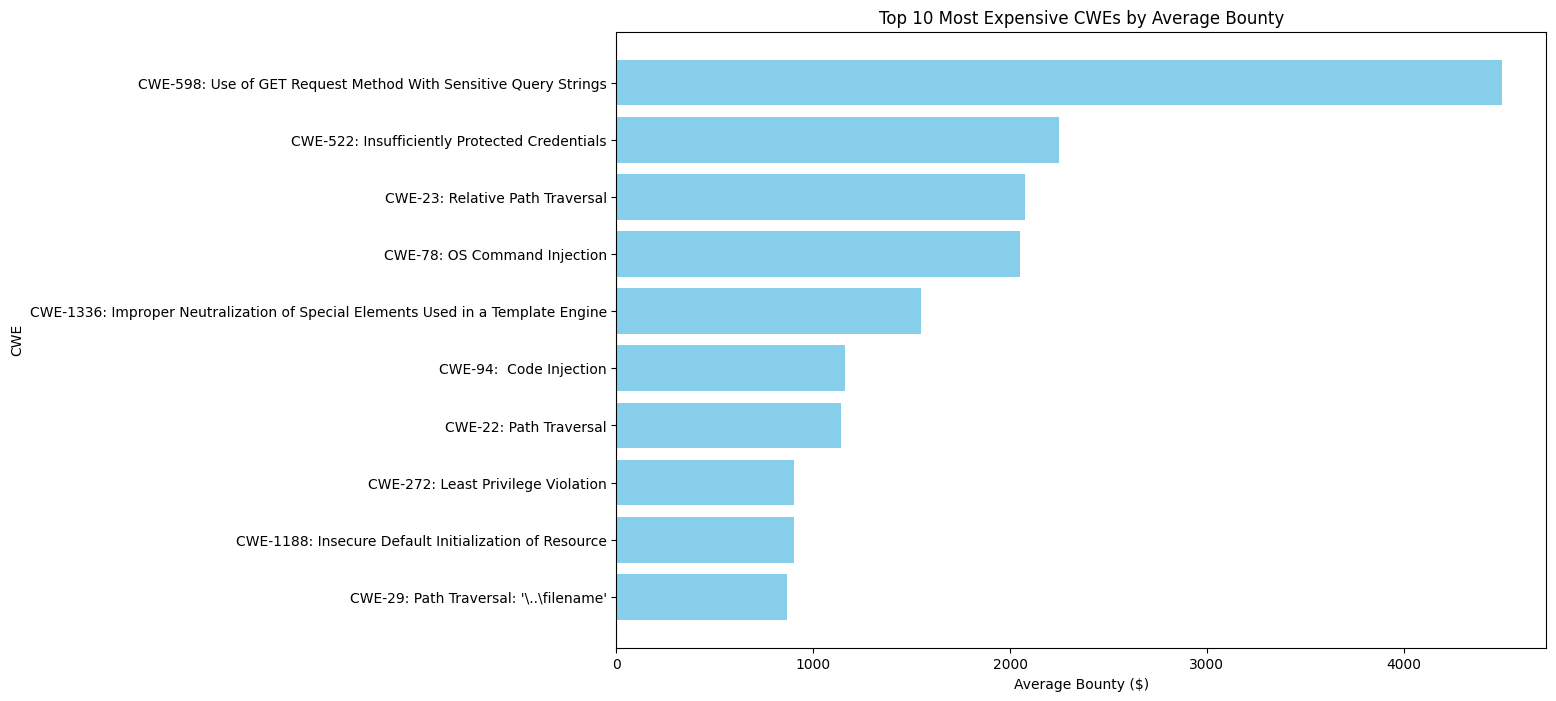

In [19]:
plot_top_cwes(overall_cwe_avg_bounty, top_n=10)

Most expensive CWEs by total bounty

In [20]:
def calculate_total_bounties(result_dict):
    cwe_bounty_sum = defaultdict(float)
    
    for repo, entries in result_dict.items():
        for entry in entries:
            bounty = float(entry.get('disclosure_bounty', 0))
            if bounty > 0:
                cwes = entry.get('cwe', [])
                for cwe in cwes:
                    cwe_bounty_sum[cwe] += bounty
                    
    return cwe_bounty_sum

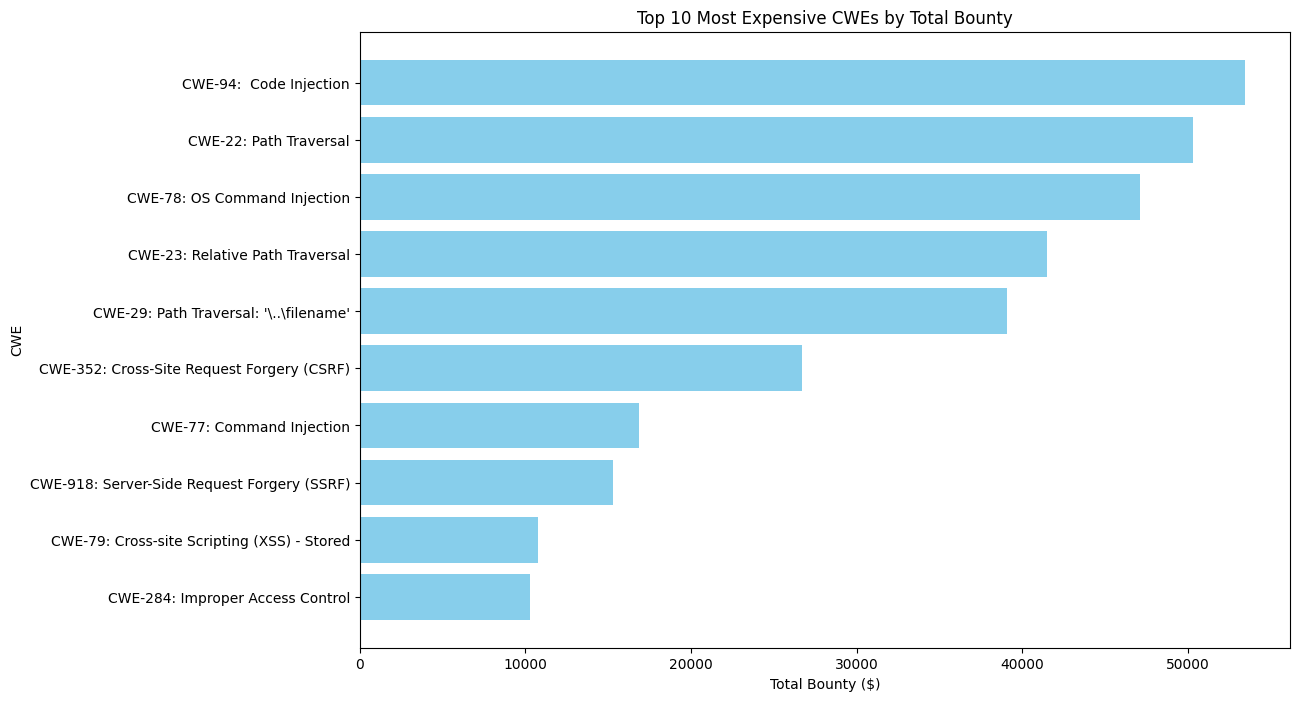

In [218]:
def plot_top_cwes_by_total_bounty(cwe_bounty_sum, top_n=10):
    # Sort CWEs by total bounty in descending order and select top N
    sorted_cwes = dict(sorted(cwe_bounty_sum.items(), key=lambda item: item[1], reverse=True)[:top_n])
    
    cwes = list(sorted_cwes.keys())
    total_bounties = [sorted_cwes[cwe] for cwe in cwes]
    
    plt.figure(figsize=(12, 8))
    plt.barh(cwes, total_bounties, color='skyblue')
    plt.xlabel('Total Bounty ($)')
    plt.ylabel('CWE')
    plt.title(f'Top {top_n} Most Expensive CWEs by Total Bounty')
    plt.gca().invert_yaxis()  
    plt.show()

# Calculate total bounties
cwe_bounty_sum = calculate_total_bounties(result)

# Plot top 10 most expensive CWEs by total bounty
plot_top_cwes_by_total_bounty(cwe_bounty_sum, top_n=10)

In [21]:
def calculate_bounties(result_dict):
    cwe_bounty_sum = defaultdict(float)
    cwe_bounty_count = defaultdict(int)
    
    for repo, entries in result_dict.items():
        for entry in entries:
            bounty = float(entry.get('disclosure_bounty', 0))
            if bounty > 0:
                cwes = entry.get('cwe', [])
                for cwe in cwes:
                    cwe_bounty_sum[cwe] += bounty
                    cwe_bounty_count[cwe] += 1
                    
    return cwe_bounty_sum, cwe_bounty_count

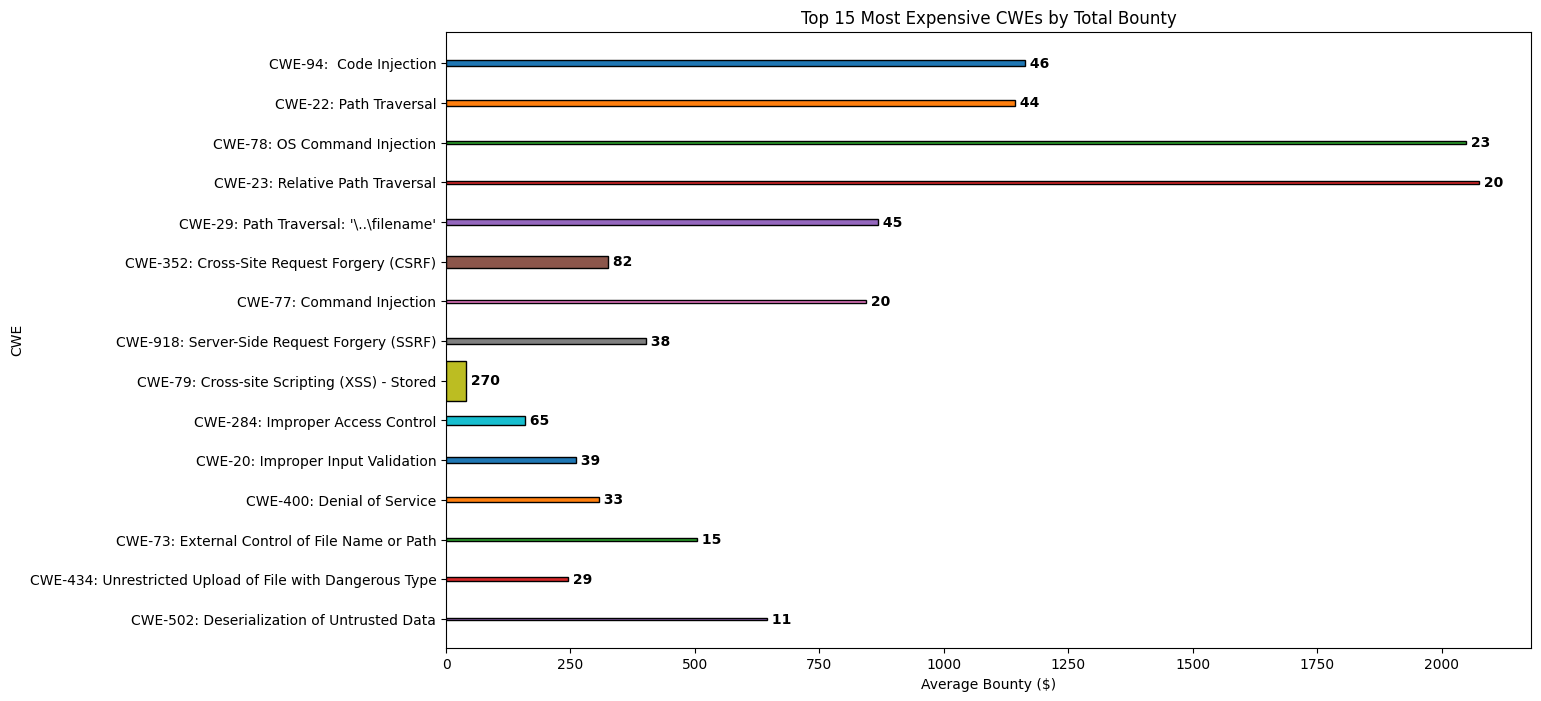

In [22]:
def plot_cwes_by_bounty(cwe_bounty_sum, cwe_bounty_count, cwe_avg_bounty, top_n=20):
    # Sort CWEs by total bounty in descending order and select top N
    sorted_cwes = sorted(cwe_bounty_sum.items(), key=lambda item: item[1], reverse=True)[:top_n]
    
    cwes = [cwe for cwe, _ in sorted_cwes]
    total_bounties = [cwe_bounty_sum[cwe] for cwe in cwes]
    avg_bounties = [cwe_avg_bounty[cwe] for cwe in cwes]
    frequencies = [cwe_bounty_count[cwe] for cwe in cwes]
    
    max_freq = max(frequencies)
    height_factor = 1.0 / max_freq  # Normalize the bar width to the maximum frequency
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for i in range(top_n):
        ax.barh(cwes[i], avg_bounties[i], height=frequencies[i] * height_factor, edgecolor='black')
    
    # Add labels and title
    ax.set_xlabel('Average Bounty ($)')
    ax.set_ylabel('CWE')
    ax.set_title(f'Top {top_n} Most Expensive CWEs by Total Bounty')
    for i in range(top_n):
        ax.text(avg_bounties[i], i, f' {frequencies[i]}', va='center', ha='left', color='black', fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.show()

cwe_bounty_sum, cwe_bounty_count = calculate_bounties(result)
plot_cwes_by_bounty(cwe_bounty_sum, cwe_bounty_count, overall_cwe_avg_bounty, top_n=15)
#width reflects frequency

In [10]:
def aggregate_cwe_occurrences_by_year(result_dict):
    cwe_year_count = defaultdict(lambda: defaultdict(int))
    
    for repo, entries in result_dict.items():
        for entry in entries:
            date = entry.get('date', None)
            if isinstance(date, datetime):
                year = date.year
                cwes = entry.get('cwe', [])
                for cwe in cwes:
                    cwe_year_count[cwe][year] += 1
                    
    return cwe_year_count

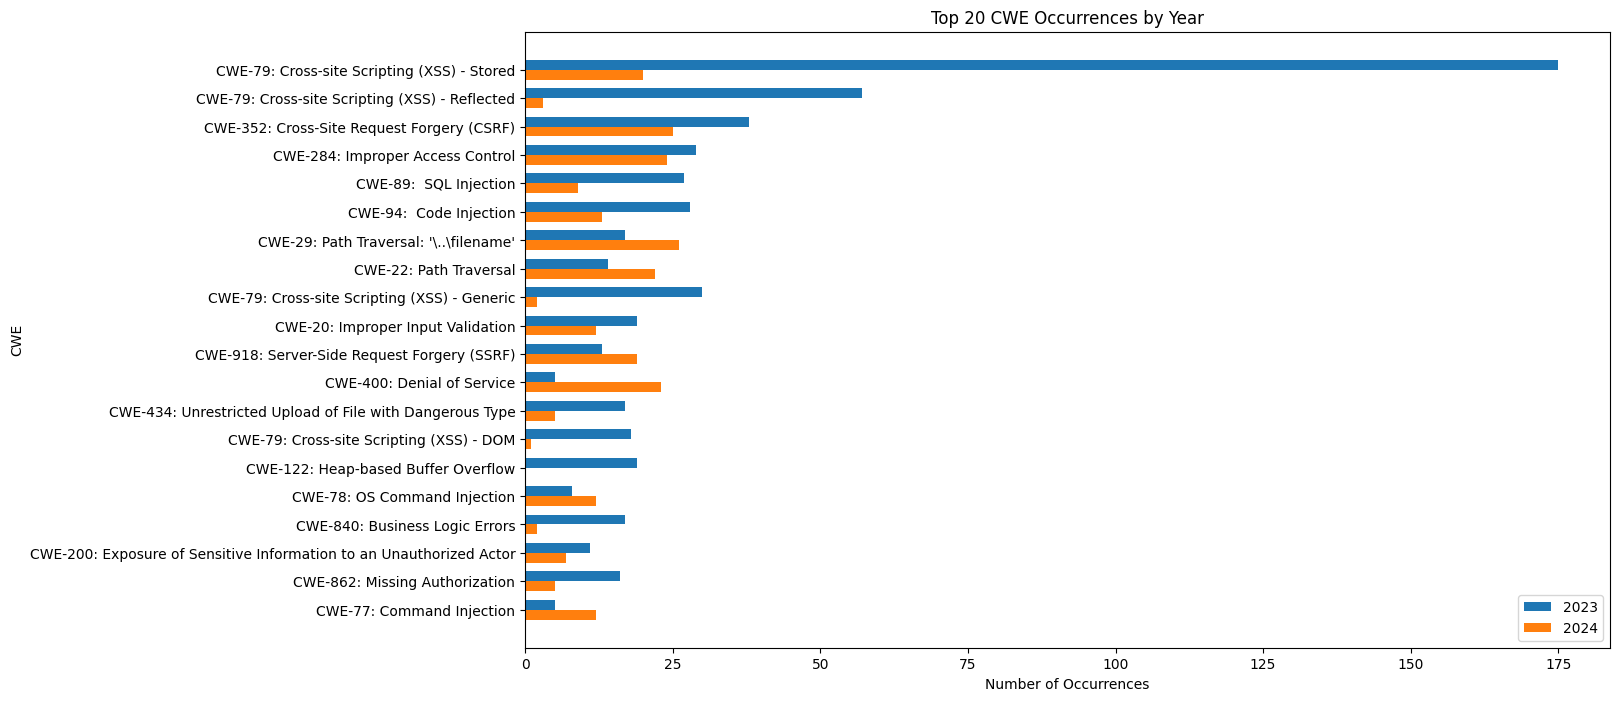

In [11]:
def plot_grouped_cwe_occurrences(cwe_year_count, years, top_n=20):
    # Sort CWEs by total occurrences and select top N
    cwe_total_occurrences = {cwe: sum(year_count.values()) for cwe, year_count in cwe_year_count.items()}
    sorted_cwes = sorted(cwe_total_occurrences.items(), key=lambda item: item[1], reverse=True)[:top_n]
    
    cwes = [cwe for cwe, _ in sorted_cwes]
    year_occurrences = {year: [cwe_year_count[cwe][year] for cwe in cwes] for year in years}
    
    ind = np.arange(len(cwes))  # the y locations for the groups
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(14, 8))

    # Place bars side by side
    for i, year in enumerate(years):
        ax.barh(ind + i * width, year_occurrences[year], width, label=str(year))
    
    ax.set_xlabel('Number of Occurrences')
    ax.set_ylabel('CWE')
    ax.set_title(f'Top {top_n} CWE Occurrences by Year')
    ax.set_yticks(ind + width / len(years))  # Offset y-ticks to the middle of the groups
    ax.set_yticklabels(cwes)
    ax.invert_yaxis() 
    ax.legend()

    plt.show()

# Aggregate CWE occurrences by year
cwe_year_count = aggregate_cwe_occurrences_by_year(result)

# Define the years of interest
years_of_interest = [2023, 2024]

# Plot grouped CWE occurrences
plot_grouped_cwe_occurrences(cwe_year_count, years_of_interest, top_n=20)
#top 20 for all years combined

In [12]:
def aggregate_cwe_bounties_by_year(result_dict):
    cwe_year_bounty_sum = defaultdict(lambda: defaultdict(float))
    
    for repo, entries in result_dict.items():
        for entry in entries:
            date = entry.get('date', None)
            if isinstance(date, datetime):
                year = date.year
                cwes = entry.get('cwe', [])
                bounty = float(entry.get('disclosure_bounty', 0))
                for cwe in cwes:
                    cwe_year_bounty_sum[cwe][year] += bounty
                    
    return cwe_year_bounty_sum

cwe_year_bounty_sum = aggregate_cwe_bounties_by_year(result)

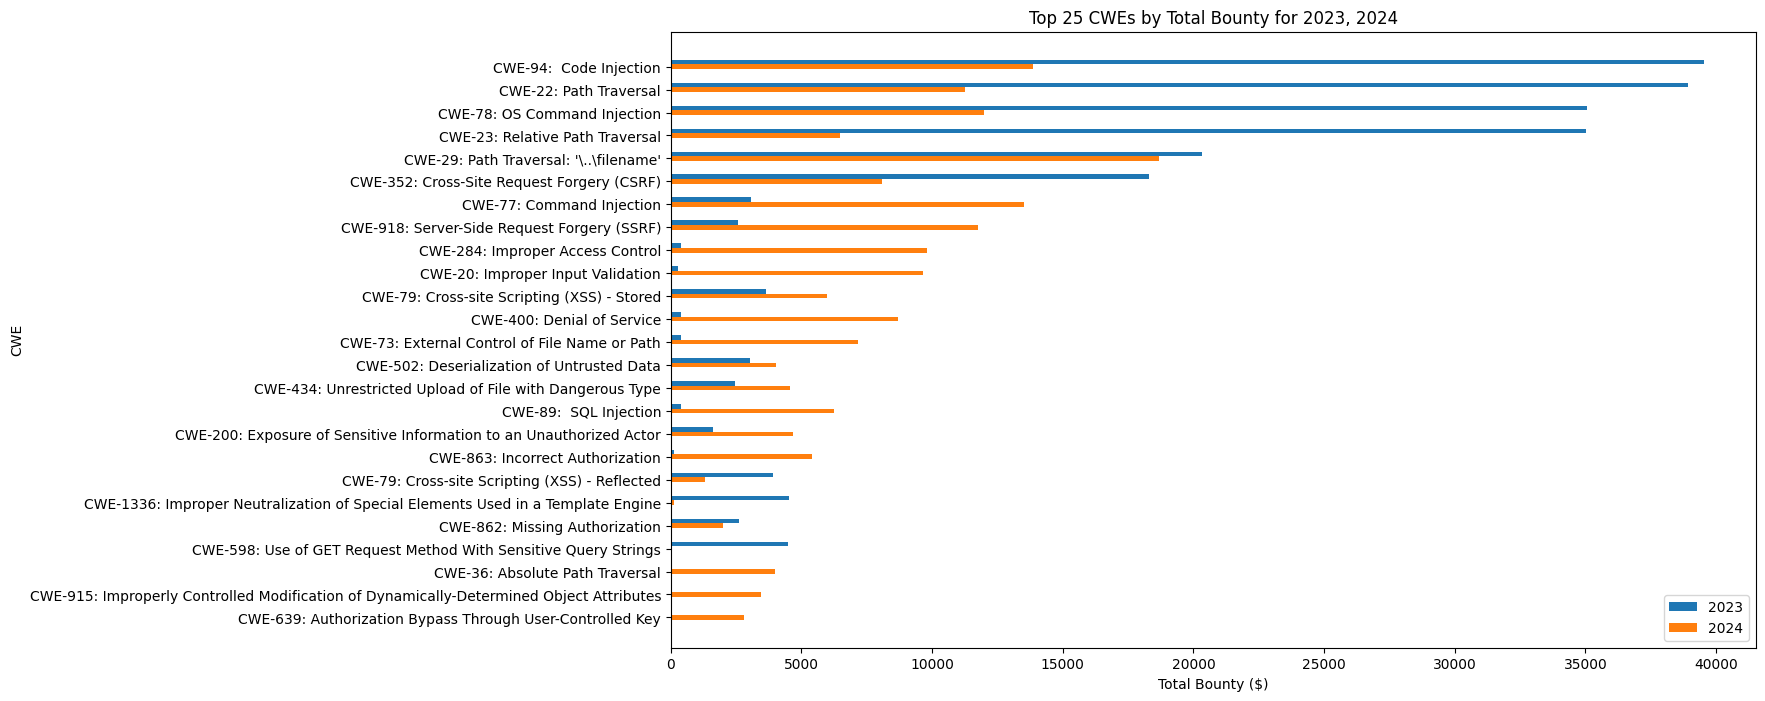

In [13]:
def plot_grouped_cwe_total_bounty(cwe_year_bounty_sum, years, top_n=20):
    # Aggregate across specified years and get the total bounty
    cwe_total_bounty = {cwe: sum(cwe_year_bounty_sum[cwe][year] for year in years if year in cwe_year_bounty_sum[cwe]) for cwe in cwe_year_bounty_sum}
    
    # Sort CWEs by total bounty and select top N
    sorted_cwes = sorted(cwe_total_bounty.items(), key=lambda item: item[1], reverse=True)[:top_n]
    
    cwes = [cwe for cwe, _ in sorted_cwes]
    year_total_bounties = {year: [cwe_year_bounty_sum[cwe][year] for cwe in cwes] for year in years}
    
    ind = np.arange(len(cwes))  # the y locations for the groups
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(14, 8))

    # Place bars side by side
    for i, year in enumerate(years):
        ax.barh(ind + i * width - width * (len(years) / 2), year_total_bounties[year], width, label=str(year))
    
    ax.set_xlabel('Total Bounty ($)')
    ax.set_ylabel('CWE')
    ax.set_title(f'Top {top_n} CWEs by Total Bounty for {", ".join(map(str, years))}')
    ax.set_yticks(ind)
    ax.set_yticklabels(cwes)
    ax.invert_yaxis() 
    ax.legend()

    plt.show()

# Define the years of interest
years_of_interest = [2023, 2024]

# Plot grouped CWE occurrences combined over all years
plot_grouped_cwe_total_bounty(cwe_year_bounty_sum, years_of_interest, top_n=25)

# n-gram

In [23]:
#Preprocesisng step: keep only CWE data to use for n-gram
repo_dict=result
cwe_data = {}
for repo, entries in repo_dict.items():
    cwes = []
    for entry in entries:
        cwe_part = entry['cwe']
        cwes.extend(cwe_part)
    cwe_data[repo] = cwes

all_cwes = []
for cwes in cwe_data.values():
    all_cwes.extend(cwes)

In [24]:
cwe_data['lunary-ai/lunary']

['CWE-250: Execution with Unnecessary Privileges',
 'CWE-200: Exposure of Sensitive Information to an Unauthorized Actor',
 'CWE-863: Incorrect Authorization',
 'CWE-863: Incorrect Authorization',
 'CWE-821: Incorrect Synchronization',
 'CWE-285: Improper Authorization',
 'CWE-863: Incorrect Authorization',
 'CWE-821: Incorrect Synchronization',
 'CWE-862: Missing Authorization',
 'CWE-284: Improper Access Control',
 'CWE-284: Improper Access Control',
 'CWE-639: Authorization Bypass Through User-Controlled Key',
 'CWE-639: Authorization Bypass Through User-Controlled Key',
 'CWE-639: Authorization Bypass Through User-Controlled Key',
 'CWE-862: Missing Authorization',
 'CWE-284: Improper Access Control',
 'CWE-821: Incorrect Synchronization',
 'CWE-640: Weak Password Recovery Mechanism for Forgotten Password',
 'CWE-1125: Excessive Attack Surface',
 'CWE-284: Improper Access Control',
 'CWE-862: Missing Authorization',
 'CWE-284: Improper Access Control',
 'CWE-918: Server-Side Reques

### n=3 n-gram (experimental & deprecated)

In [29]:

repo_dict = sorted_result

def split_data(repo_dict, test_size=0.2):
    train_dict = {}
    test_dict = {}

    for repo, entries in repo_dict.items():
        if len(entries) > 1:
            # Only split if there are at least 2 entries to avoid empty train/test sets
            train_entries, test_entries = train_test_split(entries, test_size=test_size, random_state=42)
            train_dict[repo] = train_entries
            test_dict[repo] = test_entries
        else:
            # Use all entries for training if there's 1 or no entries (not ideal for evaluation)
            train_dict[repo] = entries
            test_dict[repo] = []
    
    return train_dict, test_dict

def extract_cwe_data(repo_dict):
    cwe_data = {}
    for repo, entries in repo_dict.items():
        cwes = []
        for entry in entries:
            cwe_part = entry['cwe']
            cwes.extend([item.split(":")[0].strip() for item in cwe_part])
        cwe_data[repo] = cwes
    return cwe_data

def train_ngram_model(cwe_data, n=3):
    cwe_ngrams = Counter()
    for repo, cwes in cwe_data.items():
        for ngram in ngrams(cwes, n):
            cwe_ngrams[ngram] += 1
    return cwe_ngrams

def predict_next_cwe(prefix, cwe_ngrams, n=3):
    prefix = tuple(prefix.split())[-(n-1):]
    candidates = [ngram[-1] for ngram in cwe_ngrams if ngram[:-1] == prefix]
    prediction = Counter(candidates).most_common(1)
    return prediction[0][0] if prediction else None

def evaluate_model(test_dict, cwe_ngrams, n=3):
    total_cases = 0
    correct_predictions = 0
    
    for repo, entries in test_dict.items():
        for entry in entries:
            cwes = [item.split(":")[0].strip() for item in entry['cwe']]
            for i in range(len(cwes) - n + 1):
                total_cases += 1
                prefix = ' '.join(cwes[i:i+n-1])
                actual_cwe = cwes[i+n-1]
                predicted_cwe = predict_next_cwe(prefix, cwe_ngrams, n)
                if predicted_cwe == actual_cwe:
                    correct_predictions += 1
    
    accuracy = correct_predictions / total_cases if total_cases > 0 else 0
    return accuracy

# Main execution
train_dict, test_dict = split_data(repo_dict, test_size=0.2)

# Ensure `cwe_data` is extracted from training set
cwe_data = extract_cwe_data(train_dict)
n = 3  # Tri-gram model
cwe_ngrams = train_ngram_model(cwe_data, n=n)

accuracy = evaluate_model(test_dict, cwe_ngrams, n=n)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Example prediction
prefix = 'CWE-284 CWE-400'
predicted_cwe = predict_next_cwe(prefix, cwe_ngrams, n=n)
print(f"Given prefix: '{prefix}', predicted next CWE: {predicted_cwe}")

# Predict next CWEs for a specific repository
repo = 'lunary-ai/lunary'
if repo in test_dict:
    correct_cwe_sequence = [item for sublist in test_dict[repo] for item in extract_cwe_data({repo: [sublist]})[repo]]
    print(f"Actual CWE sequence for repository '{repo}':")
    print(correct_cwe_sequence)
    
    if repo in cwe_data and len(cwe_data[repo]) >= n-1:
        current_sequence = cwe_data[repo][:n-1]
        print(f"Initial sequence (n-1): {current_sequence}")
        predicted_cwe_sequence = list(current_sequence)
    
        # Predict next CWEs (Limited to length of correct sequence)
        for _ in range(len(correct_cwe_sequence) - len(current_sequence)):
            next_cwe = predict_next_cwe(' '.join(current_sequence), cwe_ngrams, n=n)
            if next_cwe:
                predicted_cwe_sequence.append(next_cwe)
                current_sequence.append(next_cwe)
                current_sequence = current_sequence[-(n-1):]  # Slide the window
            else:
                break
    
        print(f"Predicted CWE sequence for repository '{repo}':")
        print(predicted_cwe_sequence)

Model Accuracy: 50.00%
Given prefix: 'CWE-284 CWE-400', predicted next CWE: CWE-400
Actual CWE sequence for repository 'lunary-ai/lunary':
['CWE-89', 'CWE-639', 'CWE-863', 'CWE-352', 'CWE-821', 'CWE-284', 'CWE-284', 'CWE-639']
Initial sequence (n-1): ['CWE-862', 'CWE-640']
Predicted CWE sequence for repository 'lunary-ai/lunary':
['CWE-862', 'CWE-640', 'CWE-284', 'CWE-75', 'CWE-250', 'CWE-821', 'CWE-306', 'CWE-284']


In [30]:
prefix = 'CWE-284 CWE-400'
predicted_cwe = predict_next_cwe(prefix, cwe_ngrams, n=n)
print(f"Given prefix: '{prefix}', predicted next CWE: {predicted_cwe}")

Given prefix: 'CWE-284 CWE-400', predicted next CWE: CWE-400


ok this doesn't work. which makes sense because i don't think they have that strong of a time dependence 

## Most Common CWE

In [32]:

repo_dict = result

# Example frequency-based approach
def split_data(repo_dict, test_size=0.2):
    train_dict = {}
    test_dict = {}

    for repo, entries in repo_dict.items():
        if len(entries) > 1:
            # Only split if there are at least 2 entries to avoid empty train/test sets
            train_entries, test_entries = train_test_split(entries, test_size=test_size, random_state=42)
            train_dict[repo] = train_entries
            test_dict[repo] = test_entries
        else:
            # Use all entries for training if there's 1 or no entries (not ideal for evaluation)
            train_dict[repo] = entries
            test_dict[repo] = []
    
    return train_dict, test_dict

def extract_cwe_data(repo_dict):
    cwe_data = {}
    for repo, entries in repo_dict.items():
        cwes = []
        for entry in entries:
            cwe_part = entry['cwe']
            cwes.extend([item.split(":")[0].strip() for item in cwe_part])
        cwe_data[repo] = cwes
    return cwe_data

def predict_most_common_cwe_per_repo(train_dict):
    most_common_cwe_per_repo = {}
    for repo, cwes in train_dict.items():
        cwe_counter = Counter(cwes)
        most_common_cwe = cwe_counter.most_common(1)
        if most_common_cwe:
            most_common_cwe_per_repo[repo] = most_common_cwe[0][0]
    return most_common_cwe_per_repo

def evaluate_frequency_model(test_dict, most_common_cwe):
    total_cases = 0
    correct_predictions = 0
    
    for repo, entries in test_dict.items():
        print(f"Repo: {repo}, most common cwe: {most_common_cwe[repo]}")
        for entry in entries:
                total_cases += 1
                if entry == most_common_cwe[repo]:
                    correct_predictions += 1
    
    accuracy = correct_predictions / total_cases if total_cases > 0 else 0
    return accuracy

# Main execution
train_dict, test_dict = split_data(repo_dict, test_size=0.2)

# Extract CWE data for each repository
train_cwe_data = extract_cwe_data(train_dict)
test_cwe_data = extract_cwe_data(test_dict)
total_cwe_data = extract_cwe_data(repo_dict)
# Predict using the most common CWE per repository
most_common_cwe_per_repo = predict_most_common_cwe_per_repo(total_cwe_data)

# Evaluate the frequency-based model
accuracy = evaluate_frequency_model(total_cwe_data, most_common_cwe_per_repo)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Repo: pkp/pkp-lib, most common cwe: CWE-79
Repo: langchain-ai/chat-langchain, most common cwe: CWE-79
Repo: parisneo/lollms-webui, most common cwe: CWE-29
Repo: gpac/gpac, most common cwe: CWE-122
Repo: parisneo/lollms, most common cwe: CWE-22
Repo: firefly-iii/firefly-iii, most common cwe: CWE-20
Repo: omeka/omeka-s, most common cwe: CWE-79
Repo: nuxtlabs/github-module, most common cwe: CWE-798
Repo: froxlor/froxlor, most common cwe: CWE-94
Repo: mintplex-labs/anything-llm, most common cwe: CWE-20
Repo: os4ed/opensis-classic, most common cwe: CWE-22
Repo: pimcore/pimcore, most common cwe: CWE-79
Repo: thorsten/phpmyfaq, most common cwe: CWE-79
Repo: usememos/memos, most common cwe: CWE-79
Repo: bits-and-blooms/bloom, most common cwe: CWE-427
Repo: lunary-ai/lunary, most common cwe: CWE-284
Repo: dolibarr/dolibarr, most common cwe: CWE-79
Repo: open-webui/open-webui, most common cwe: CWE-400
Repo: gaizhenbiao/chuanhuchatgpt, most common cwe: CWE-284
Repo: answerdev/answer, most common 

Top 3 with no extra weighting 

In [35]:

repo_dict = sorted_result

# Example frequency-based approach
def split_data(repo_dict, test_size=0.2):
    train_dict = {}
    test_dict = {}

    for repo, entries in repo_dict.items():
        if len(entries) > 1:
            # Only split if there are at least 2 entries to avoid empty train/test sets
            train_entries, test_entries = train_test_split(entries, test_size=test_size, random_state=42)
            train_dict[repo] = train_entries
            test_dict[repo] = test_entries
        else:
            # Use all entries for training if there's 1 or no entries (not ideal for evaluation)
            train_dict[repo] = entries
            test_dict[repo] = []
    
    return train_dict, test_dict

def extract_cwe_data(repo_dict):
    cwe_data = {}
    for repo, entries in repo_dict.items():
        cwes = []
        for entry in entries:
            cwe_part = entry.get('cwe', [])
            cwes.extend([item.split(":")[0].strip() for item in cwe_part])
        cwe_data[repo] = cwes
    return cwe_data

def predict_top_3_cwe_per_repo(train_dict):
    top_3_cwe_per_repo = {}
    for repo, cwes in train_dict.items():
        cwe_counter = Counter(cwes)
        total_count = sum(cwe_counter.values())
        top_3_cwe = cwe_counter.most_common(3)
        top_3_cwe_with_percentage = [(cwe, count / total_count * 100) for cwe, count in top_3_cwe]
        top_3_cwe_per_repo[repo] = top_3_cwe_with_percentage
    return top_3_cwe_per_repo

def evaluate_frequency_model(test_dict, top_3_cwe_per_repo):
    total_cases = 0
    correct_predictions = 0
    
    for repo, entries in test_dict.items():
        if repo in top_3_cwe_per_repo:
            for entry in entries:
                total_cases += 1
                cwe_list = [top_cwe[0] for top_cwe in top_3_cwe_per_repo[repo]]
                if entry in cwe_list:
                    correct_predictions += 1
    
    accuracy = correct_predictions / total_cases if total_cases > 0 else 0
    return accuracy

# Main execution
train_dict, test_dict = split_data(repo_dict, test_size=0.2)

# Extract CWE data for each repository
train_cwe_data = extract_cwe_data(train_dict)
test_cwe_data = extract_cwe_data(test_dict)
total_cwe_data = extract_cwe_data(repo_dict)

# Predict using the top 3 CWEs per repository
top_3_cwe_per_repo = predict_top_3_cwe_per_repo(total_cwe_data)

# Evaluate the frequency-based model
accuracy = evaluate_frequency_model(test_cwe_data, top_3_cwe_per_repo)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Print the top 3 CWEs and their percentages for each repository
for repo, top_cwes in top_3_cwe_per_repo.items():
    cwe_info = ", ".join([f"{cwe} ({percentage:.2f}%)" for cwe, percentage in top_cwes])
    print(f"Repository: {repo}, Top 3 CWEs: {cwe_info}")

Model Accuracy: 72.49%
Repository: pkp/pkp-lib, Top 3 CWEs: CWE-79 (46.67%), CWE-352 (26.67%), CWE-1241 (6.67%)
Repository: langchain-ai/chat-langchain, Top 3 CWEs: CWE-79 (100.00%)
Repository: parisneo/lollms-webui, Top 3 CWEs: CWE-29 (23.26%), CWE-352 (16.28%), CWE-79 (9.30%)
Repository: gpac/gpac, Top 3 CWEs: CWE-122 (17.39%), CWE-125 (17.39%), CWE-476 (13.04%)
Repository: parisneo/lollms, Top 3 CWEs: CWE-22 (30.00%), CWE-29 (15.00%), CWE-94 (10.00%)
Repository: firefly-iii/firefly-iii, Top 3 CWEs: CWE-20 (50.00%), CWE-863 (25.00%), CWE-613 (25.00%)
Repository: omeka/omeka-s, Top 3 CWEs: CWE-79 (50.00%), CWE-918 (12.50%), CWE-20 (12.50%)
Repository: nuxtlabs/github-module, Top 3 CWEs: CWE-798 (100.00%)
Repository: froxlor/froxlor, Top 3 CWEs: CWE-94 (13.79%), CWE-352 (13.79%), CWE-77 (6.90%)
Repository: mintplex-labs/anything-llm, Top 3 CWEs: CWE-20 (13.73%), CWE-400 (11.76%), CWE-918 (9.80%)
Repository: os4ed/opensis-classic, Top 3 CWEs: CWE-22 (66.67%), CWE-89 (33.33%)
Repository:

Top 3 weighted by bounty

In [36]:


# Example frequency-based approach
def split_data(repo_dict, test_size=0.2):
    train_dict = {}
    test_dict = {}

    for repo, entries in repo_dict.items():
        if len(entries) > 1:
            # Only split if there are at least 2 entries to avoid empty train/test sets
            train_entries, test_entries = train_test_split(entries, test_size=test_size, random_state=42)
            train_dict[repo] = train_entries
            test_dict[repo] = test_entries
        else:
            # Use all entries for training if there's 1 or no entries (not ideal for evaluation)
            train_dict[repo] = entries
            test_dict[repo] = []
    
    return train_dict, test_dict

def extract_cwe_data(repo_dict):
    cwe_data = {}
    for repo, entries in repo_dict.items():
        cwes = []
        for entry in entries:
            cwe_part = entry.get('cwe', [])
            bounty = entry.get('disclosure_bounty', '0')
            try:
                bounty = float(bounty)
                cwes.extend([(item.split(":")[0].strip(), bounty) for item in cwe_part if bounty > 0])
            except ValueError:
                continue
        cwe_data[repo] = cwes
    return cwe_data

def predict_top_3_cwe_per_repo(train_dict):
    top_3_cwe_per_repo = {}
    for repo, cwes in train_dict.items():
        if not cwes:
            continue
        
        cwe_counter = Counter([cwe for cwe, bounty in cwes])
        cwe_bounty_sum = defaultdict(float)
        
        for cwe, bounty in cwes:
            cwe_bounty_sum[cwe] += bounty
        
        total_count = sum(cwe_counter.values())
        max_bounty = max(cwe_bounty_sum.values())
        
        # Normalize bounties if max_bounty is greater than 0
        cwe_normalized_bounty = {cwe: cwe_bounty_sum[cwe] / max_bounty for cwe in cwe_counter} if max_bounty > 0 else {}
        
        # Combine frequency and normalized bounty to create a score
        cwe_score = {cwe: (cwe_counter[cwe] / total_count) * 0.7 + cwe_normalized_bounty.get(cwe, 0) * 0.3 for cwe in cwe_counter}
        
        # Get the top 3 CWEs based on the combined score
        top_3_cwe = sorted(cwe_score.items(), key=lambda item: item[1], reverse=True)[:3]
        top_3_cwe_with_percentage = [(cwe, score * 100) for cwe, score in top_3_cwe]
        
        top_3_cwe_per_repo[repo] = top_3_cwe_with_percentage
    return top_3_cwe_per_repo

def evaluate_frequency_model(test_dict, top_3_cwe_per_repo):
    total_cases = 0
    correct_predictions = 0
    
    for repo, entries in test_dict.items():
        if repo in top_3_cwe_per_repo:
            top_3_cwes = [cwe for cwe, _ in top_3_cwe_per_repo[repo]]
            for entry in entries:
                total_cases += 1
                entry_cwes = entry
                if any(cwe in top_3_cwes for cwe in entry_cwes):
                    correct_predictions += 1
    
    accuracy = correct_predictions / total_cases if total_cases > 0 else 0
    return accuracy

# Main execution
train_dict, test_dict = split_data(repo_dict, test_size=0.2)

# Extract CWE data for each repository
train_cwe_data = extract_cwe_data(train_dict)
test_cwe_data = extract_cwe_data(test_dict)
total_cwe_data = extract_cwe_data(repo_dict)

# Predict using the top 3 CWEs per repository
top_3_cwe_per_repo = predict_top_3_cwe_per_repo(total_cwe_data)

# Evaluate the frequency-based model
accuracy = evaluate_frequency_model(test_cwe_data, top_3_cwe_per_repo)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Print the top 3 CWEs and their weighted scores for each repository
for repo, top_cwes in top_3_cwe_per_repo.items():
    cwe_info = ", ".join([f"{cwe} ({score:.2f}%)" for cwe, score in top_cwes])
    print(f"Repository: {repo}, Top 3 CWEs: {cwe_info}")

Model Accuracy: 70.74%
Repository: pkp/pkp-lib, Top 3 CWEs: CWE-79 (58.67%), CWE-1241 (34.67%), CWE-352 (30.67%)
Repository: langchain-ai/chat-langchain, Top 3 CWEs: CWE-79 (100.00%)
Repository: parisneo/lollms-webui, Top 3 CWEs: CWE-29 (46.28%), CWE-352 (19.16%), CWE-78 (15.47%)
Repository: gpac/gpac, Top 3 CWEs: CWE-122 (42.17%), CWE-125 (42.17%), CWE-476 (31.63%)
Repository: parisneo/lollms, Top 3 CWEs: CWE-22 (50.07%), CWE-29 (40.50%), CWE-98 (16.83%)
Repository: firefly-iii/firefly-iii, Top 3 CWEs: CWE-20 (65.00%), CWE-863 (32.50%), CWE-613 (32.50%)
Repository: omeka/omeka-s, Top 3 CWEs: CWE-79 (65.00%), CWE-918 (16.25%), CWE-20 (16.25%)
Repository: nuxtlabs/github-module, Top 3 CWEs: CWE-798 (100.00%)
Repository: froxlor/froxlor, Top 3 CWEs: CWE-94 (39.66%), CWE-352 (18.95%), CWE-305 (15.09%)
Repository: mintplex-labs/anything-llm, Top 3 CWEs: CWE-918 (36.86%), CWE-20 (27.59%), CWE-23 (21.70%)
Repository: os4ed/opensis-classic, Top 3 CWEs: CWE-22 (76.67%), CWE-89 (38.33%)
Reposit